In [24]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Предсказание погоды на следующий день: 
Будет дождь, если rainfall >=1

In [25]:
df = pd.read_csv('C:/Users/vadim/Downloads/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [26]:
df.shape

(145460, 23)

Удалим столбцы

In [27]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Удаление строк с пропущенными значениями

In [28]:
df = df.dropna()
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


Преобразование данных стобца

In [29]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

C:\Users\vadim\AppData\Local\Temp\ipykernel_17536\3734455367.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
C:\Users\vadim\AppData\Local\Temp\ipykernel_17536\3734455367.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday

In [30]:
df[df['RainTomorrow']==0.0].count()

Rainfall        97103
Humidity3pm     97103
Pressure9am     97103
RainToday       97103
RainTomorrow    97103
dtype: int64

In [31]:
df[df['RainTomorrow']==1.0].count()

Rainfall        27586
Humidity3pm     27586
Pressure9am     27586
RainToday       27586
RainTomorrow    27586
dtype: int64

Классы несбалансированы

In [32]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Преобразуем в тензор

In [33]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


#NN

In [34]:

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)
    
    # torch.nn.init.xavier_uniform_(self.fc1.weight) 

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [35]:
criterion = nn.BCELoss()

In [36]:
device = torch.device( "cpu")

In [37]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [38]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [39]:
net = Net(4)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net = net.to(device)

criterion = criterion.to(device)

for epoch in range(2000):

    train_loss = 0
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
        
    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 100 == 0:

          y_test_pred = net(X_test)
          y_test_pred = torch.squeeze(y_test_pred)

          test_loss = criterion(y_test_pred, y_test)

          test_acc = calculate_accuracy(y_test, y_test_pred)
          print(
    f'''epoch {epoch}
    Test  set - loss: {test_loss}, accuracy: {test_acc}
    ''')

epoch 0
    Test  set - loss: 7.164628505706787, accuracy: 0.2216697335243225
    
epoch 100
    Test  set - loss: 0.572073757648468, accuracy: 0.7959740161895752
    
epoch 200
    Test  set - loss: 0.5436038970947266, accuracy: 0.7788916230201721
    
epoch 300
    Test  set - loss: 0.5333545207977295, accuracy: 0.7793327569961548
    
epoch 400
    Test  set - loss: 0.515478789806366, accuracy: 0.7796936631202698
    
epoch 500
    Test  set - loss: 0.4807439148426056, accuracy: 0.7794530391693115
    
epoch 600
    Test  set - loss: 0.467812716960907, accuracy: 0.7808966040611267
    
epoch 700
    Test  set - loss: 0.4557793438434601, accuracy: 0.784826397895813
    
epoch 800
    Test  set - loss: 0.44448351860046387, accuracy: 0.7911219596862793
    
epoch 900
    Test  set - loss: 0.433699369430542, accuracy: 0.7984200716018677
    
epoch 1000
    Test  set - loss: 0.42425426840782166, accuracy: 0.8102895021438599
    
epoch 1100
    Test  set - loss: 0.417177677154541, accurac

In [40]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

In [41]:
net = torch.load(MODEL_PATH)

C:\Users\vadim\AppData\Local\Temp\ipykernel_17536\804352145.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(MODEL_PATH)


In [42]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.79      0.68      0.71     24938
weighted avg       0.82      0.84      0.82     24938



Text(0.5, 51.249999999999986, 'Predicted label')

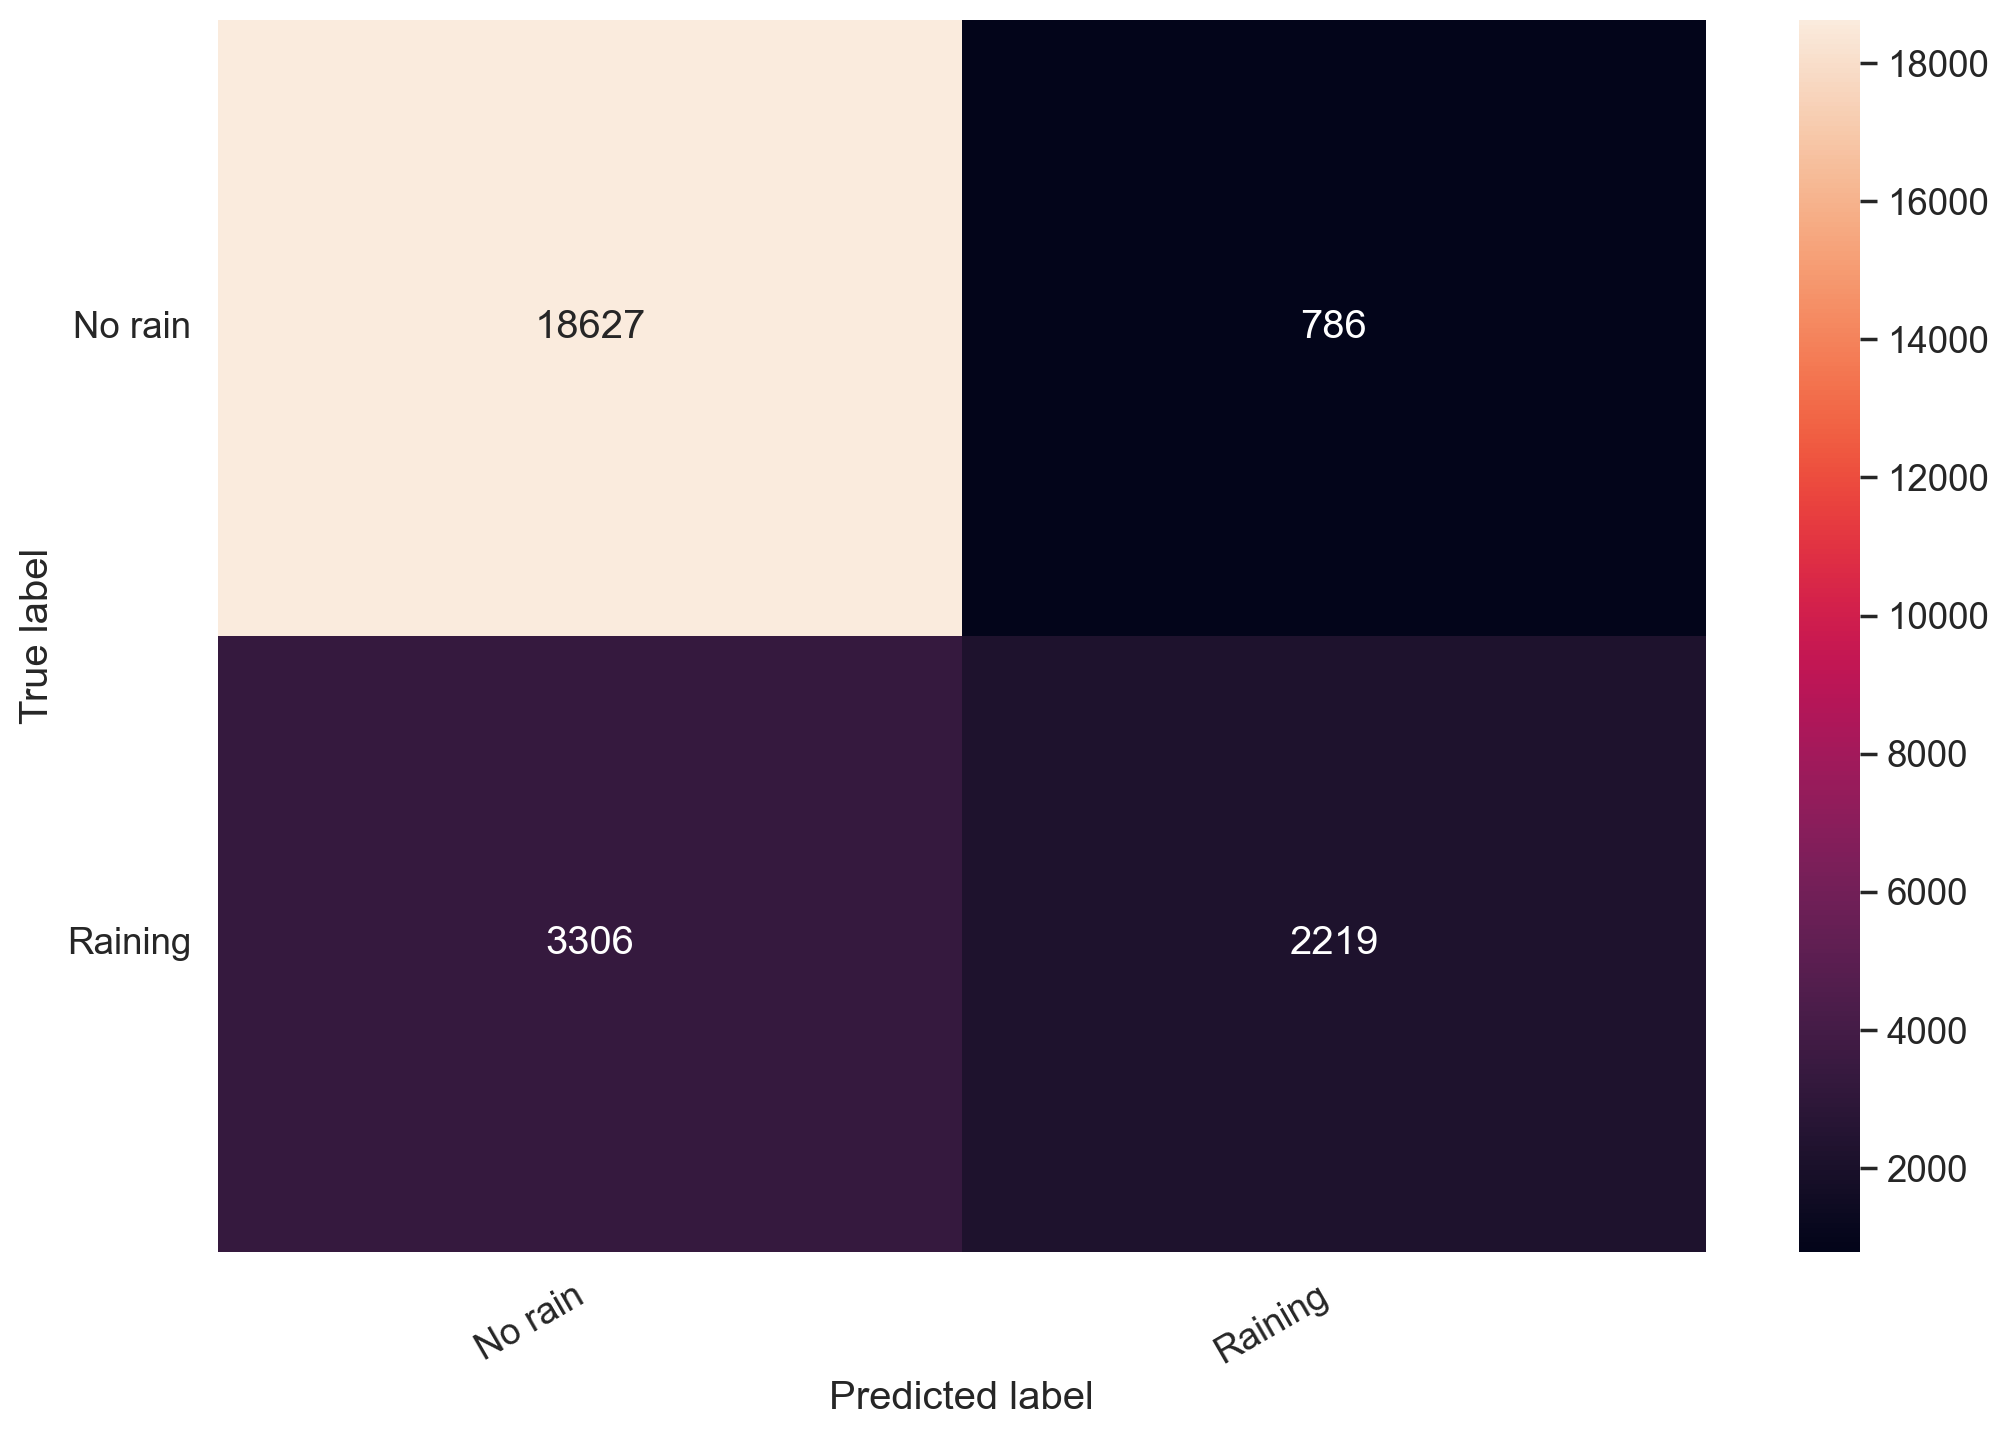

In [43]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [59]:
from sklearn.preprocessing import StandardScaler
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).squeeze()
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).squeeze()

class Net(nn.Module):
    def __init__(self, input_size, hidden_layers, activation=nn.ReLU, init_fn=None):
        super(Net, self).__init__()
        self.layers = []
        last_size = input_size

        for hidden_size in hidden_layers:
            layer = nn.Linear(last_size, hidden_size)
            if init_fn:
                init_fn(layer.weight)
            self.layers.append(layer)
            self.layers.append(activation())
            last_size = hidden_size

        self.layers.append(nn.Linear(last_size, 1))
        self.layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)
    
def train_solve(net, optimizer_class, lr, epochs, criterion, device):
    net.to(device)
    X_train_device = X_train.to(device)
    y_train_device = y_train.to(device)
    X_test_device = X_test.to(device)
    y_test_device = y_test.to(device)

    optimizer = optimizer_class(net.parameters(), lr=lr)

    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(epochs):
        net.train()
        optimizer.zero_grad()
        y_pred = net(X_train_device).squeeze()
        loss = criterion(y_pred, y_train_device)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        net.eval()
        with torch.no_grad():
            y_test_pred = net(X_test_device).squeeze()
            test_loss = criterion(y_test_pred, y_test_device)
            test_losses.append(test_loss.item())
            accuracy = ((y_test_pred >= 0.5).int() == y_test_device.int()).float().mean().item()
            accuracies.append(accuracy)

    return train_losses, test_losses, accuracies

In [45]:
# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, 
# выберите оптимальное значение.

# 2. Примените нормализацию данных. Исследуйте скорость сходимости.

# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.

# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

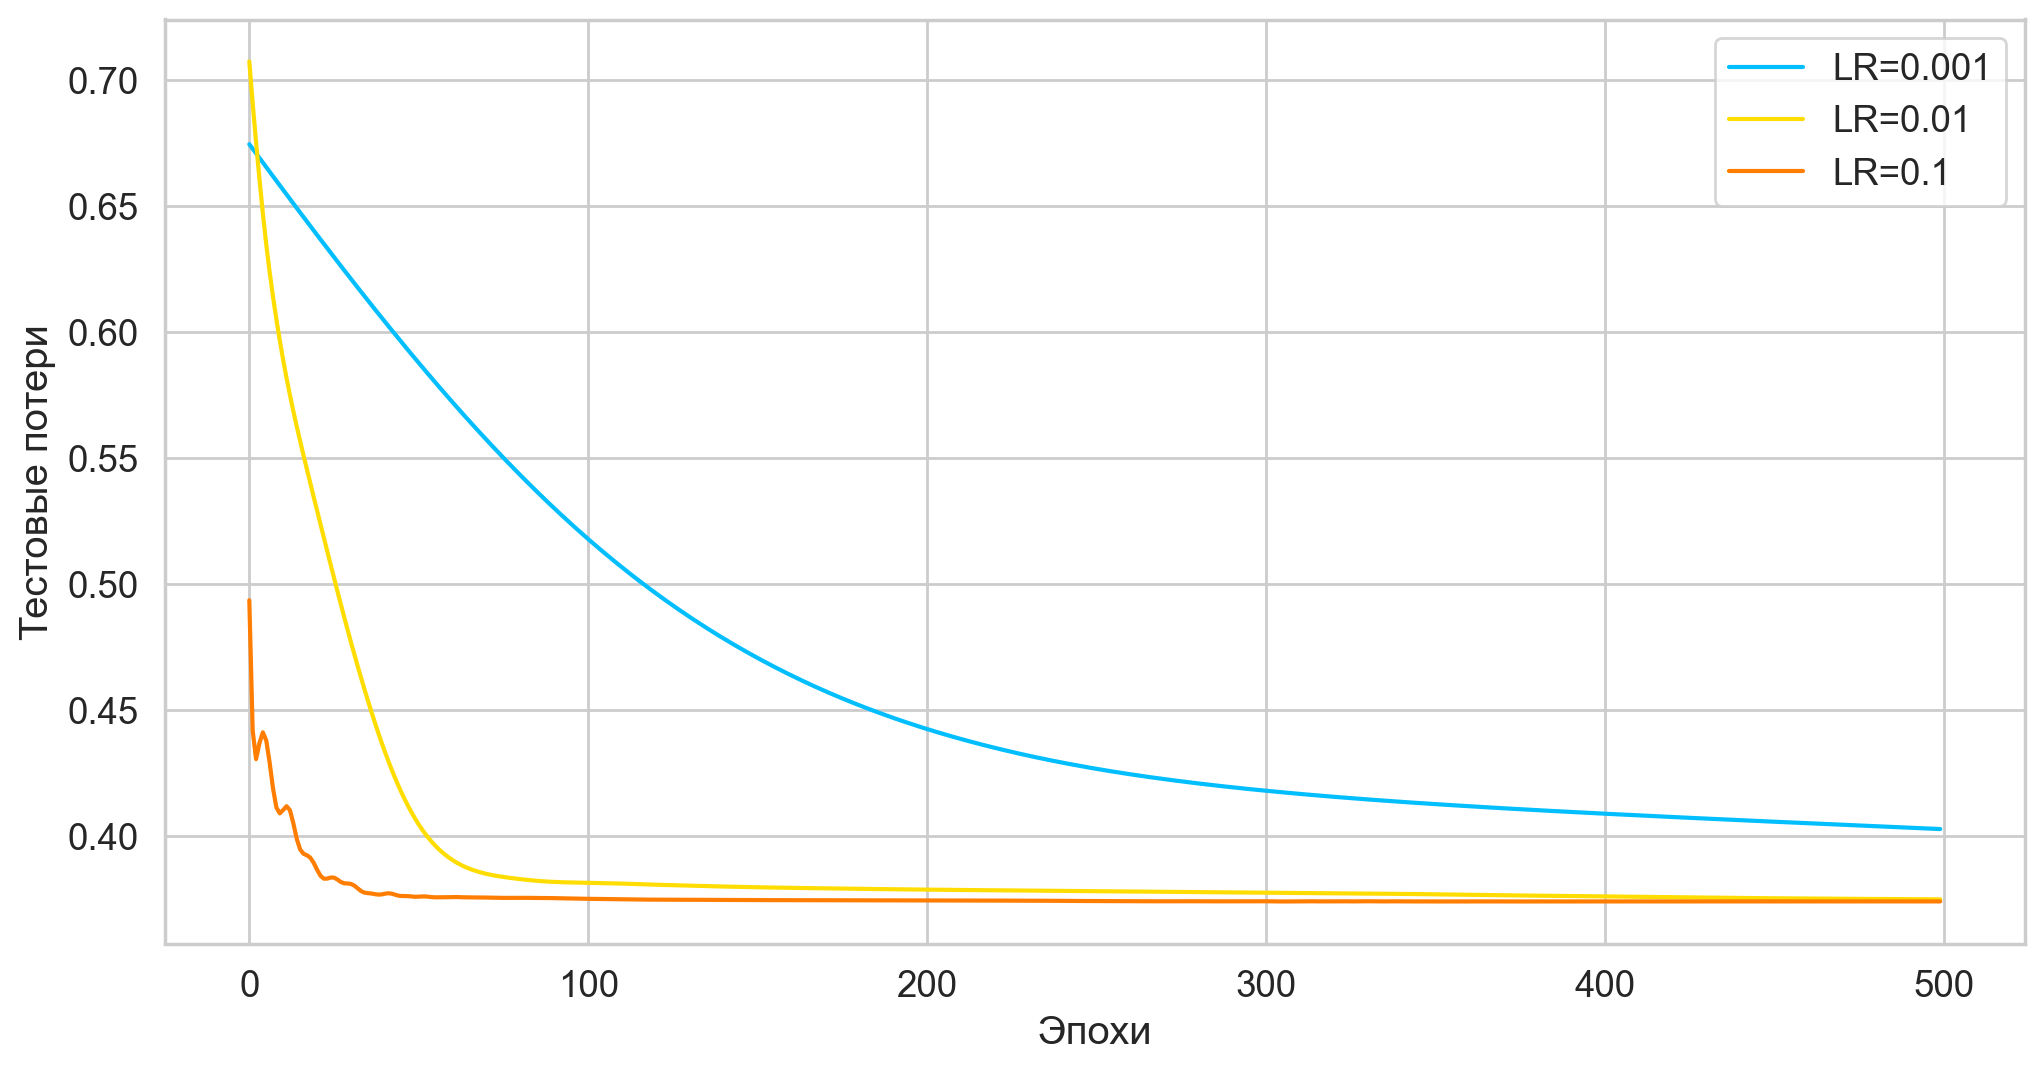

Оптимальный learning_rate: 0.1


In [61]:
# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, 
# выберите оптимальное значение.

learning_rates = [0.001, 0.01, 0.1]
results_lr = {}

for lr in learning_rates:
    net = Net(input_size=4, hidden_layers=[8])
    criterion = nn.BCELoss()
    train_losses, test_losses, accuracies = train_solve(net, optim.Adam, lr, 500, criterion, device='cpu')
    results_lr[lr] = test_losses

plt.figure(figsize=(12, 6))
for lr, test_losses in results_lr.items():
    plt.plot(test_losses, label=f'LR={lr}')
plt.xlabel('Эпохи')
plt.ylabel('Тестовые потери')
plt.legend()
plt.show()

optimal_lr = min(results_lr, key=lambda lr: min(results_lr[lr]))
print(f"Оптимальный learning_rate: {optimal_lr}")

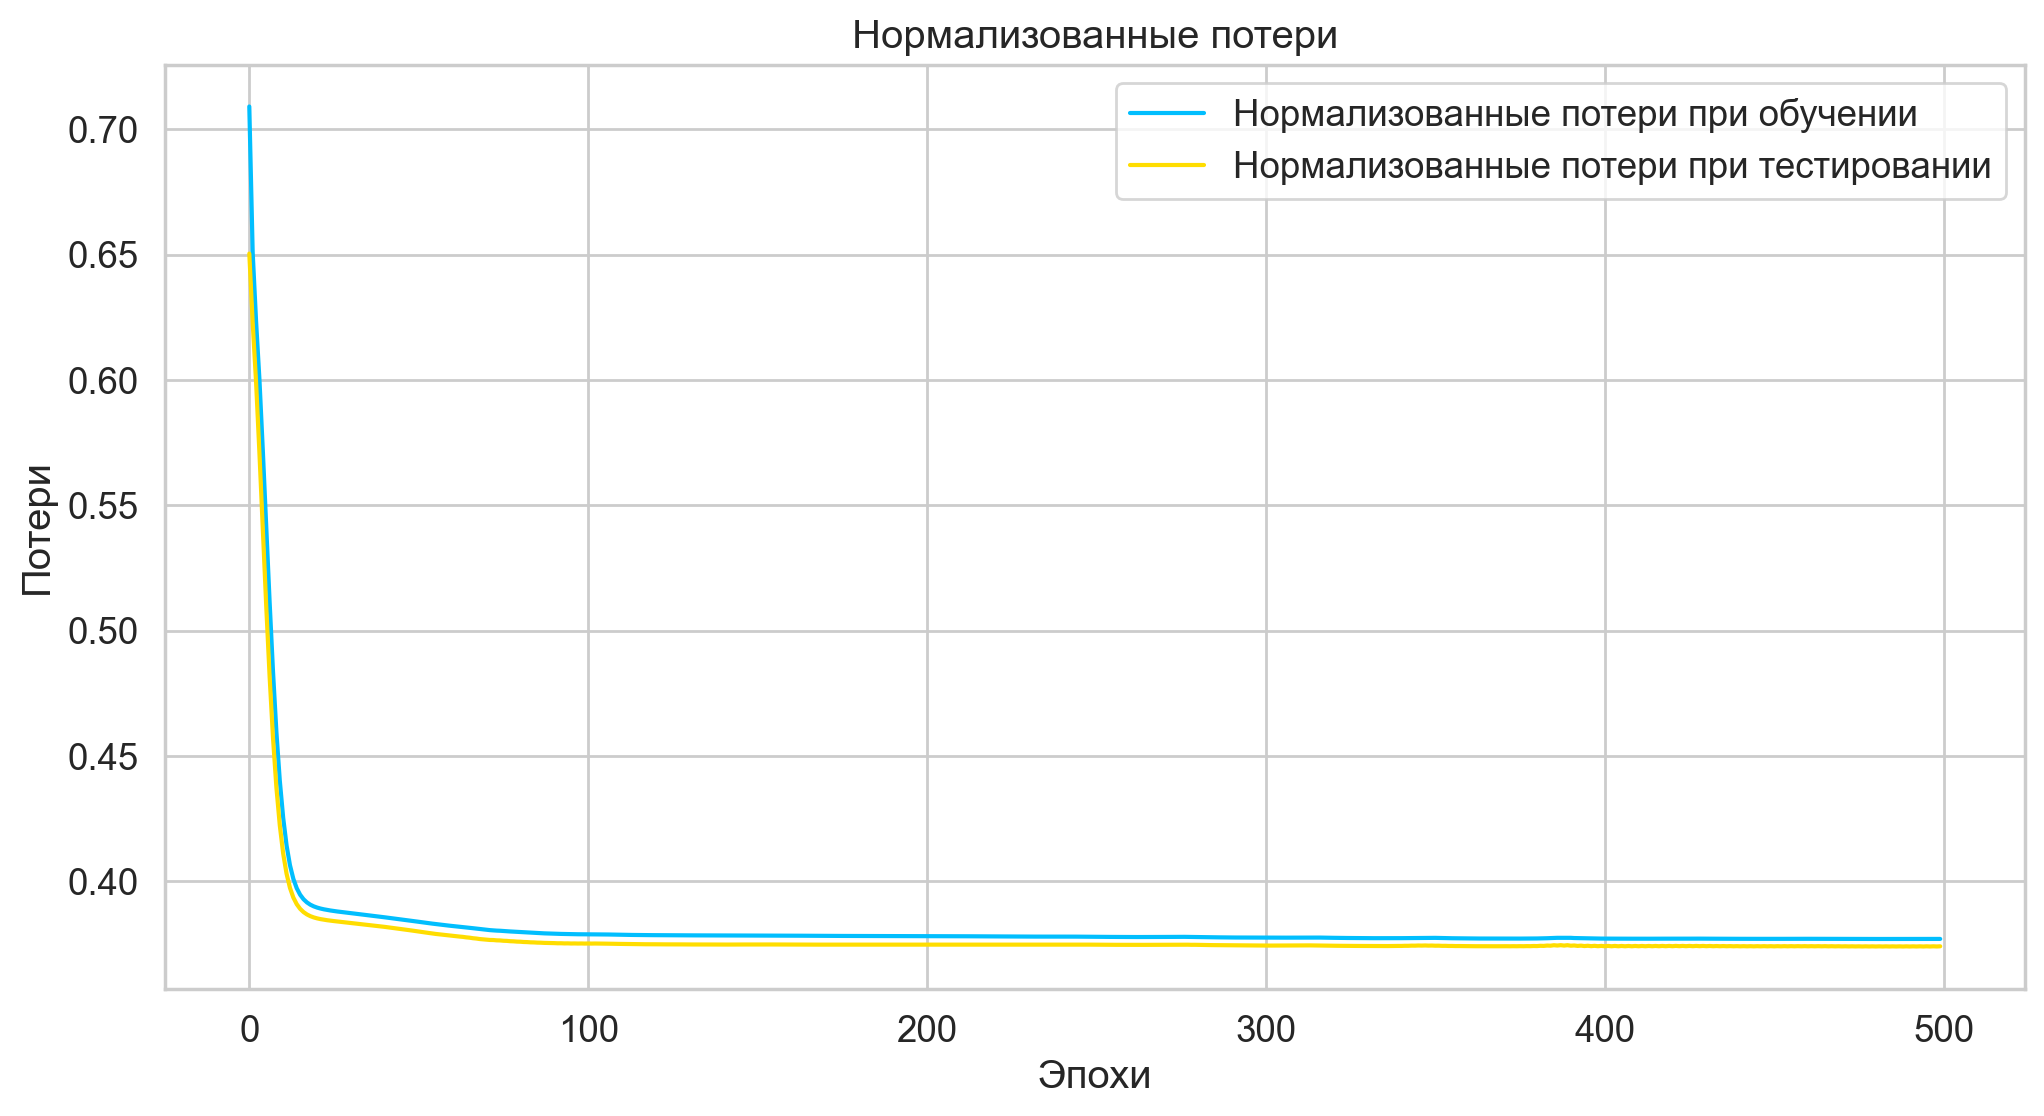

In [63]:
# 2. Примените нормализацию данных. Исследуйте скорость сходимости.
net = Net(input_size=4, hidden_layers=[8])
criterion = nn.BCELoss()
train_losses, test_losses, _ = train_solve(net, optim.RMSprop, 0.01, 500, criterion, device='cpu')

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Нормализованные потери при обучении')
plt.plot(test_losses, label='Нормализованные потери при тестировании')
plt.title('Нормализованные потери')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

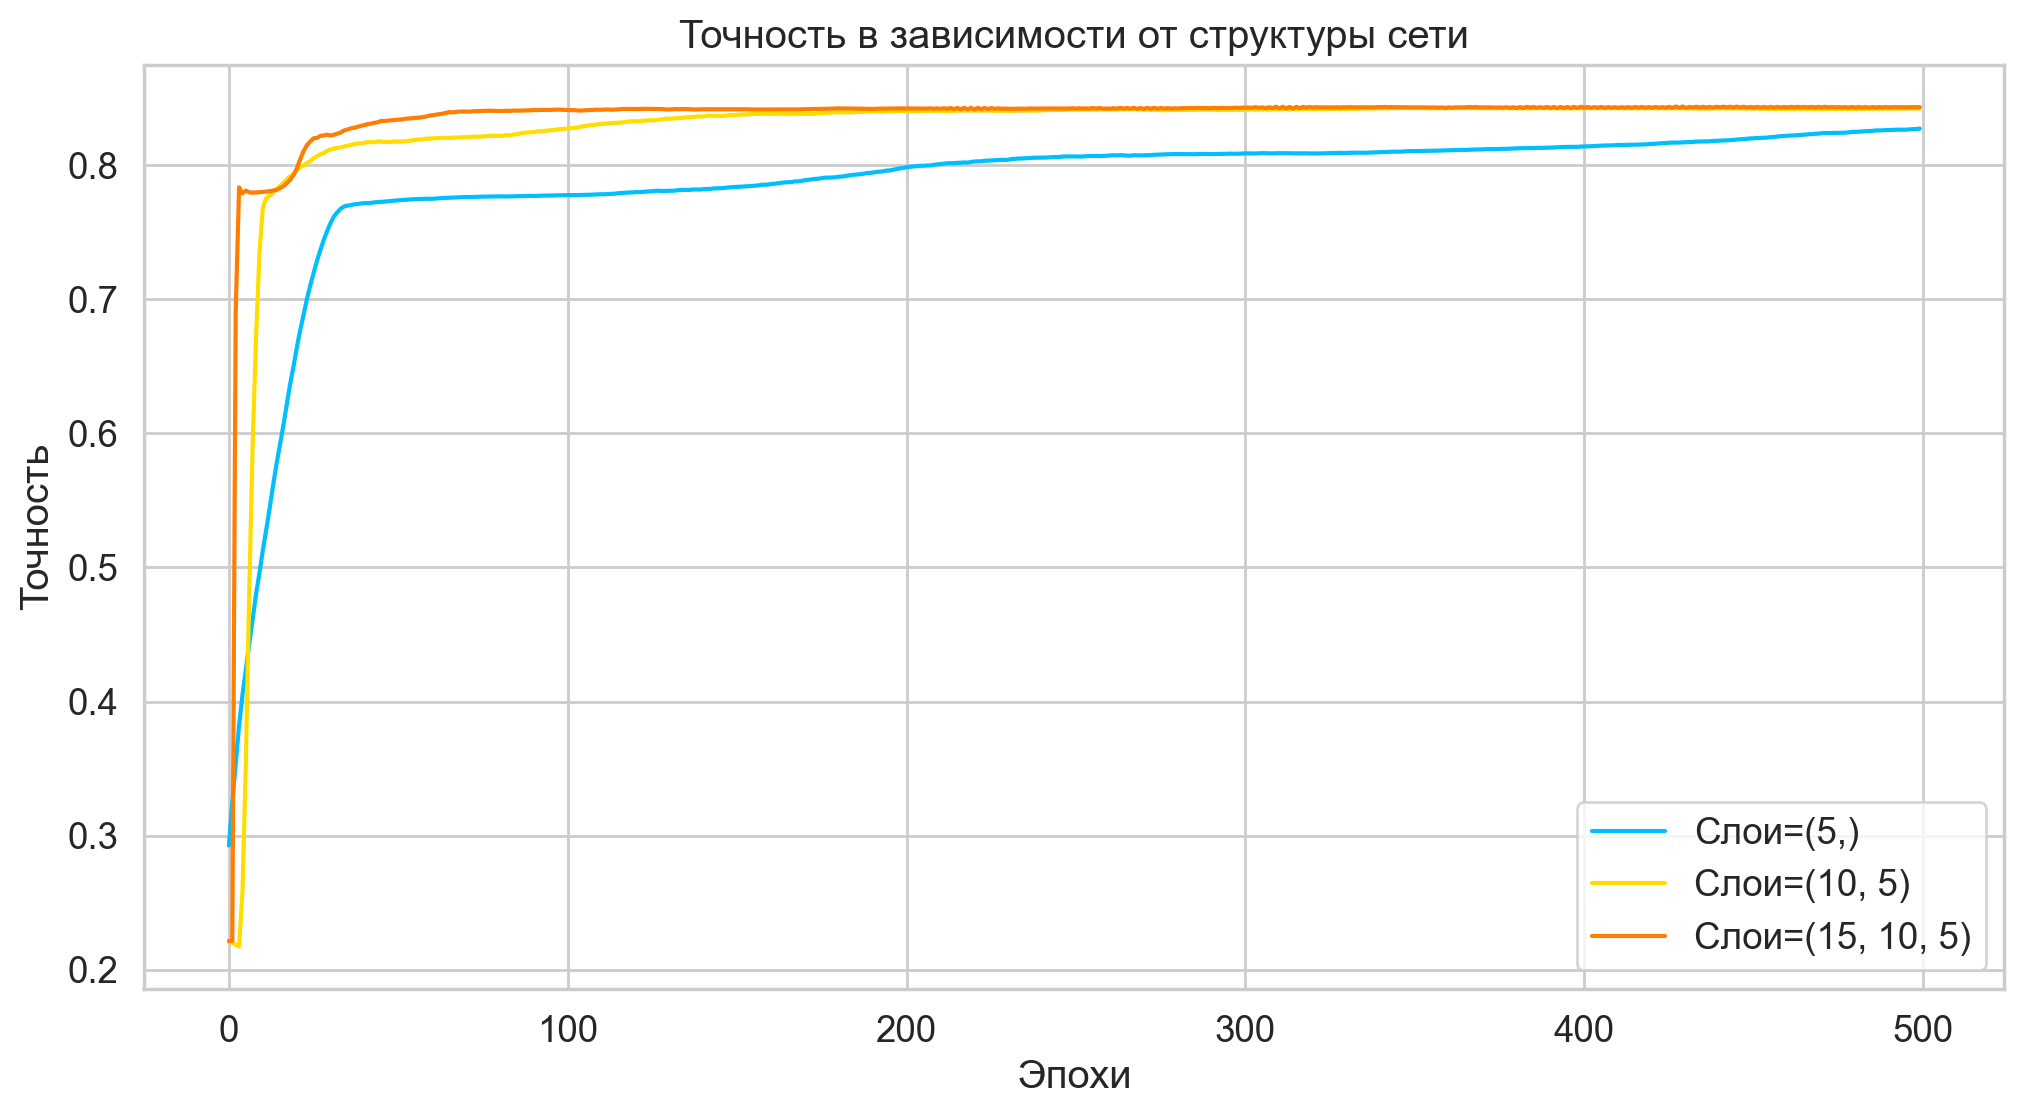

In [65]:
# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.
hidden = [[5], [10, 5], [15, 10, 5]]
results_structure = {}

for structure in hidden:
    net = Net(input_size=4, hidden_layers=structure)
    criterion = nn.BCELoss()
    train_losses, test_losses, accuracies = train_solve(net, optim.RMSprop, 0.001, 500, criterion, device='cpu')
    results_structure[tuple(structure)] = accuracies

plt.figure(figsize=(12, 6))

for structure, accuracies in results_structure.items():
    plt.plot(accuracies, label=f'Слои={structure}')

plt.title('Точность в зависимости от структуры сети')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()


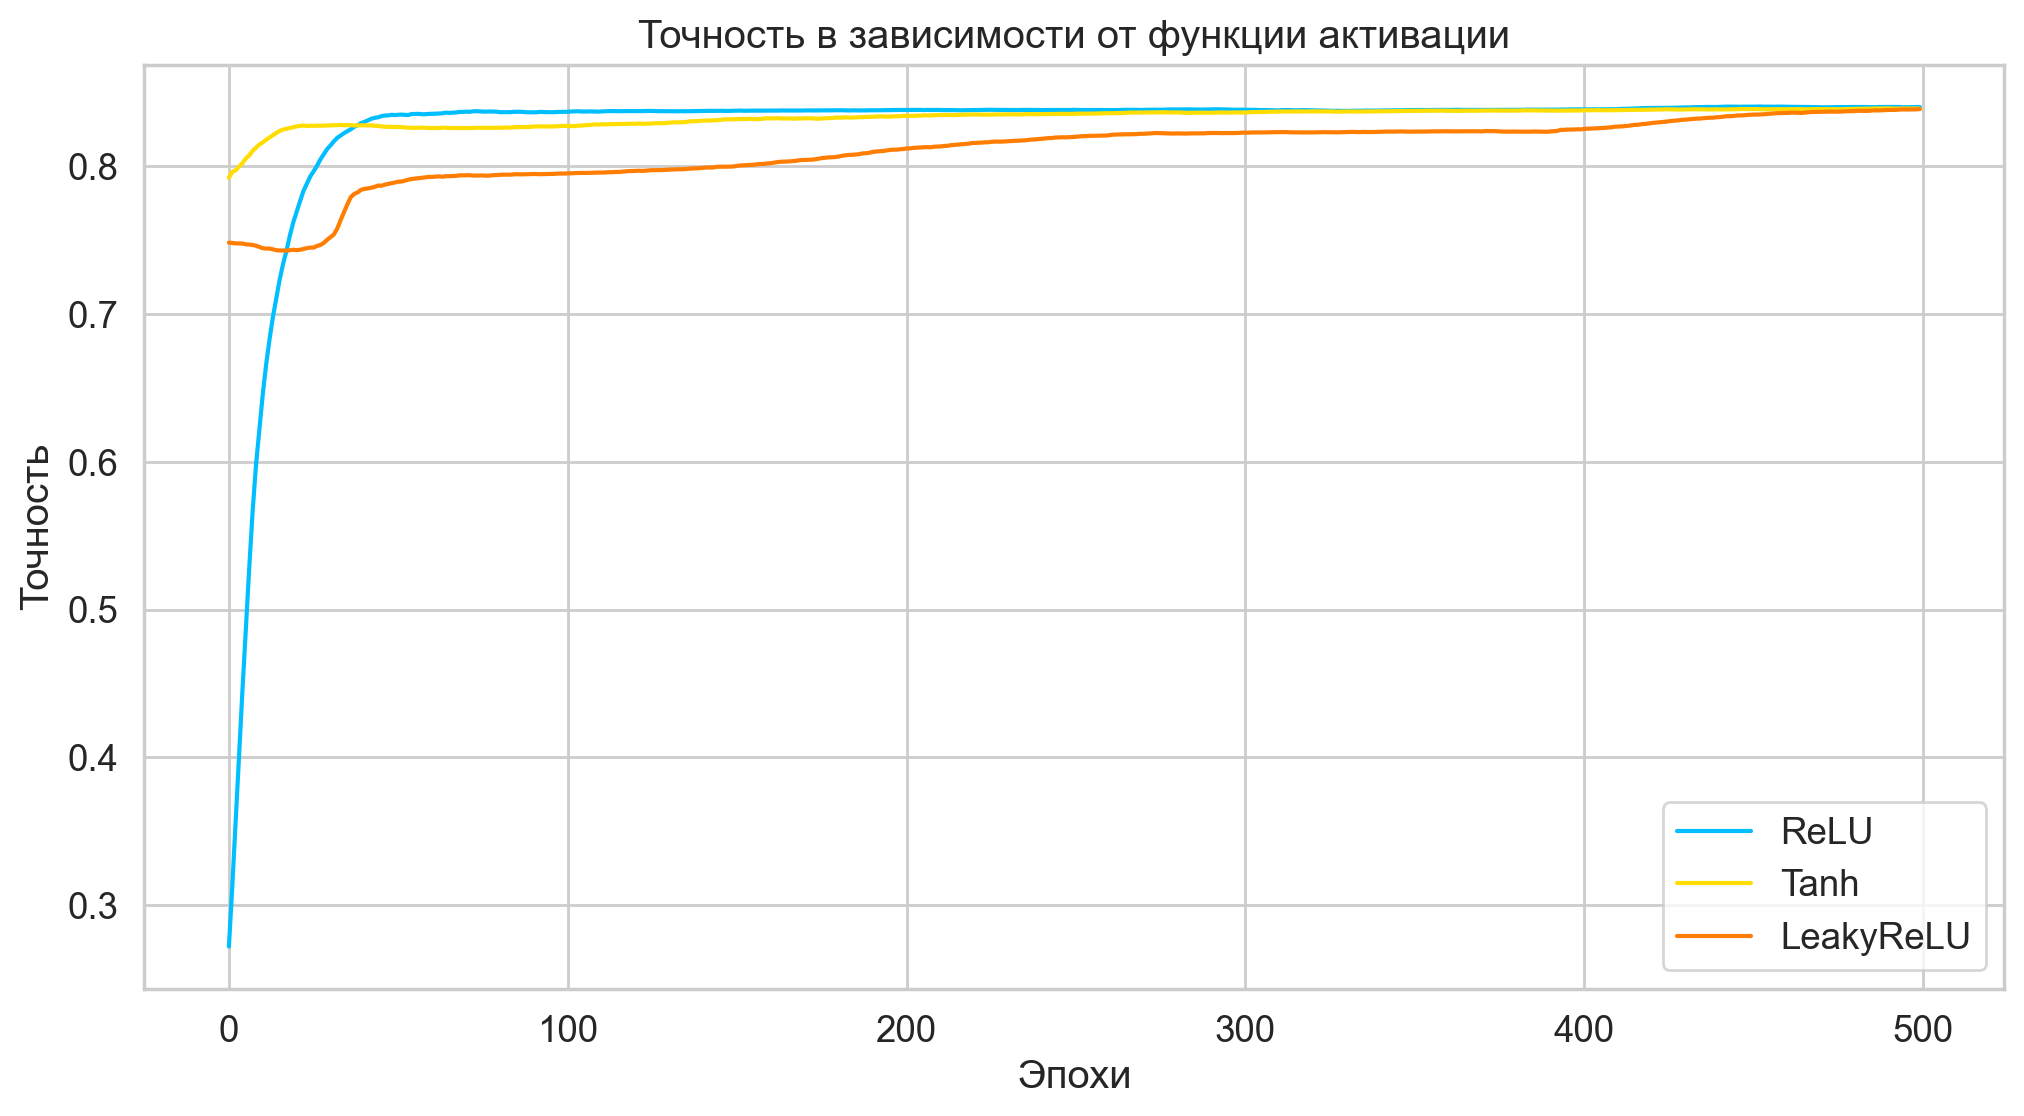

In [72]:
# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
activations = [nn.ReLU, nn.Tanh, nn.LeakyReLU]
results_activation = {}

for activation in activations:
    net = Net(input_size=4, hidden_layers=[8], activation=activation)
    criterion = nn.BCELoss()
    _, test_losses, accuracies = train_solve(net, optim.RMSprop, 0.001, 500, criterion, device='cpu')
    results_activation[activation.__name__] = accuracies

plt.figure(figsize=(12, 6))
for activation, accuracies in results_activation.items():
    plt.plot(accuracies, label=f'{activation}')
plt.title('Точность в зависимости от функции активации')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()

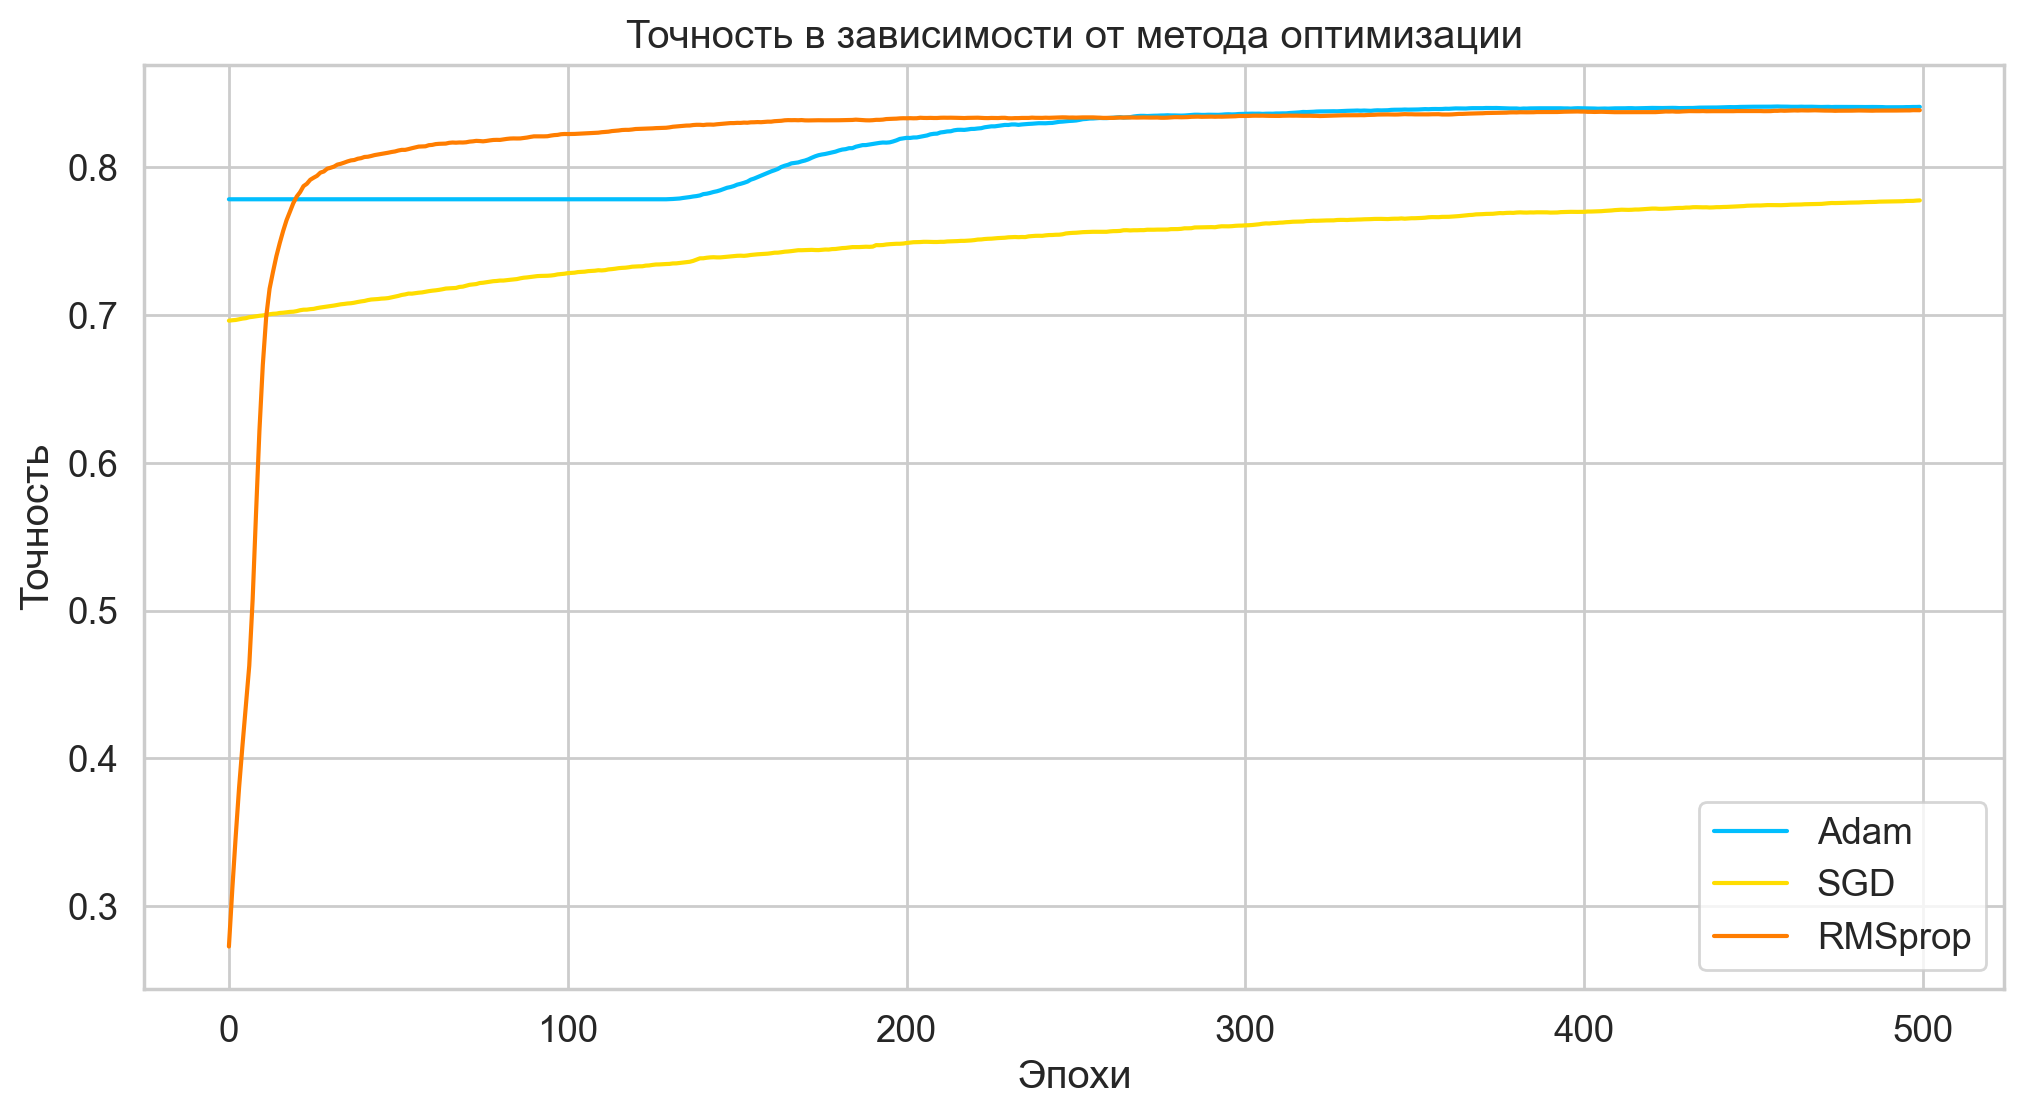

In [71]:
# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html
optimizers = [optim.Adam, optim.SGD, optim.RMSprop]

results_optim = {}
for optimizer_class in optimizers:
    net = Net(input_size=4, hidden_layers=[8])
    criterion = nn.BCELoss()
    _, test_losses, accuracies = train_solve(net, optimizer_class, 0.001, 500, criterion, device='cpu')
    results_optim[optimizer_class.__name__] = accuracies

plt.figure(figsize=(12, 6))

for optimizer, accuracies in results_optim.items():
    plt.plot(accuracies, label=f'{optimizer}')

plt.title('Точность в зависимости от метода оптимизации')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()

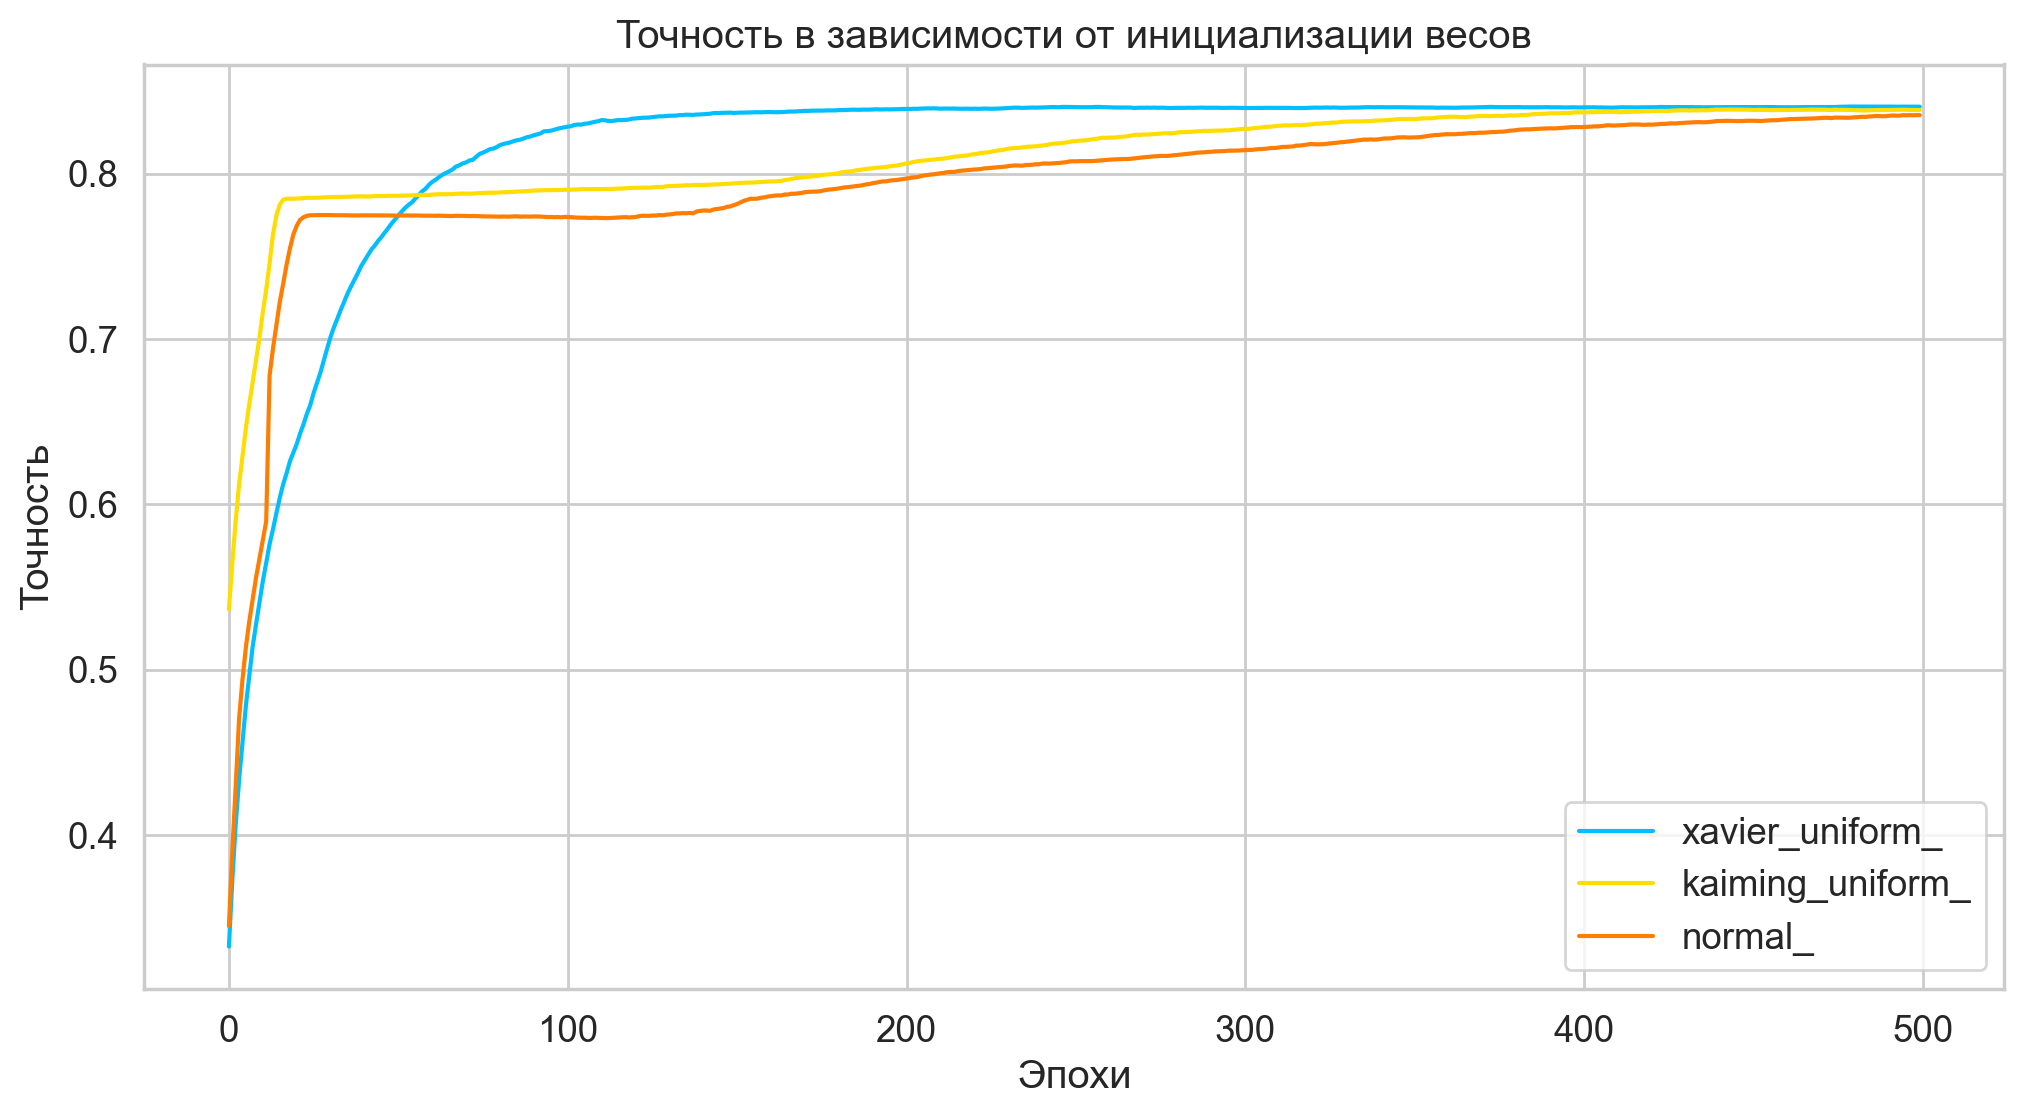

In [70]:
# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.
initializations = [
    nn.init.xavier_uniform_,
    nn.init.kaiming_uniform_,
    nn.init.normal_
]
results_init = {}
for init_fn in initializations:
    net = Net(input_size=4, hidden_layers=[8], init_fn=init_fn)
    criterion = nn.BCELoss()
    _, test_losses, accuracies = train_solve(net, optim.RMSprop, 0.001, 500, criterion, device='cpu')
    results_init[init_fn.__name__ if init_fn else 'None'] = accuracies

plt.figure(figsize=(12, 6))
for init, accuracies in results_init.items():
    plt.plot(accuracies, label=f'{init}')
plt.title('Точность в зависимости от инициализации весов')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()